In [747]:
import pandas as pd
import numpy as np
df = pd.read_csv('data.csv')

from sklearn.compose import ColumnTransformer

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from datetime import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns 

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [748]:
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [749]:
del df['SOUID']
del df['Q_TG']

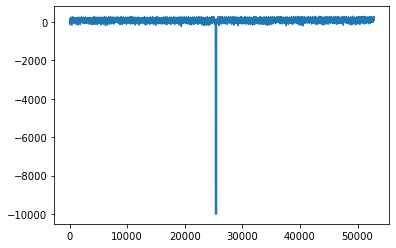

In [750]:
df['TG'].plot()              # check values, will need to fill in missing values

In [751]:
df.index[df['TG']<-800]

Int64Index([25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324,
            25325,
            ...
            25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509,
            25510],
           dtype='int64', length=195)

In [752]:
df.set_index(pd.to_datetime(df['DATE'].astype(str)), inplace=True)     # convert to datetime format
del(df['DATE'])
df['TG'] = df['TG'] / 10
df.head()

,TG
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [753]:
#df.drop(df[(df.index.month==2) & (df.index.day==29)], axis = 0)
dfsubset = df[(df.index.month==2) & (df.index.day==29)]                      # drop feb 29 values

In [754]:
df=df.drop(dfsubset.index)

In [755]:
patch44 = df.loc['1944/04/25':'1944/11/05', 'TG']                    ## fix the missing values
patch46 = df.loc['1946/04/25':'1946/11/05', 'TG']

avg = (patch44.values + patch46.values) / 2                          # mean of previous and next year

df.loc['1945/04/25':'1945/11/05', 'TG'] = avg

In [756]:
df.loc['1944/01/01':'1944/12/31', 'TG']

DATE
1944-01-01    1.8
1944-01-02    6.8
1944-01-03    5.3
1944-01-04    0.4
1944-01-05   -1.9
             ... 
1944-12-27   -6.6
1944-12-28   -3.4
1944-12-29   -5.2
1944-12-30   -4.0
1944-12-31   -0.8
Name: TG, Length: 365, dtype: float64

In [757]:
# add timestep values
df['timestep']=range(len(df.index))

In [758]:
df_train = df['1876-01':'1999-12'].copy()              # train-test split
df_test = df['2000-01':'2020-09'].copy()

In [759]:
plt.rcParams["figure.figsize"] = [20, 10]

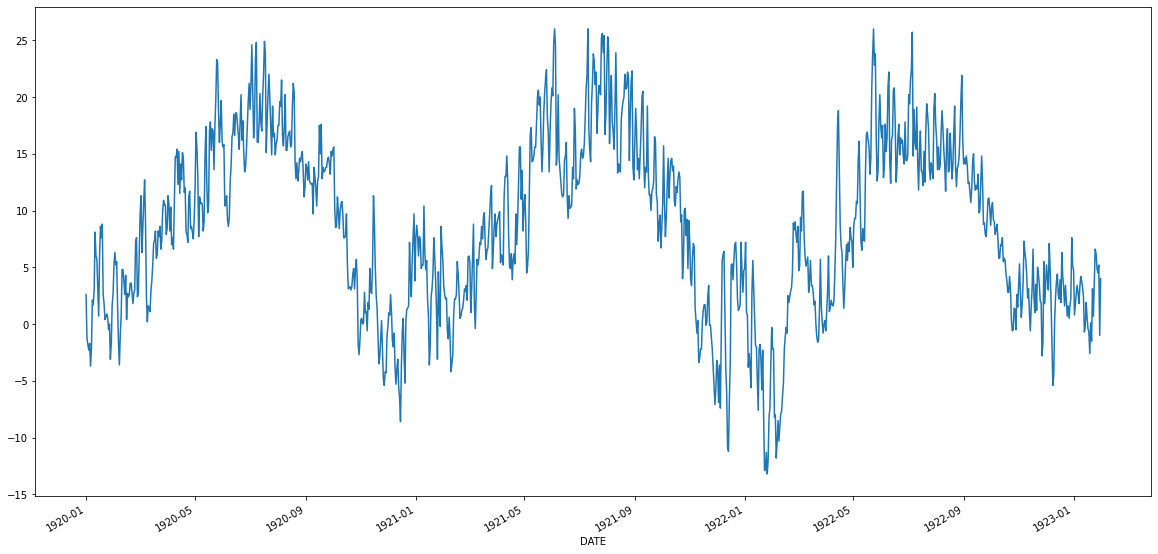

In [760]:
df_train['1920-01':'1923-01']['TG'].plot()

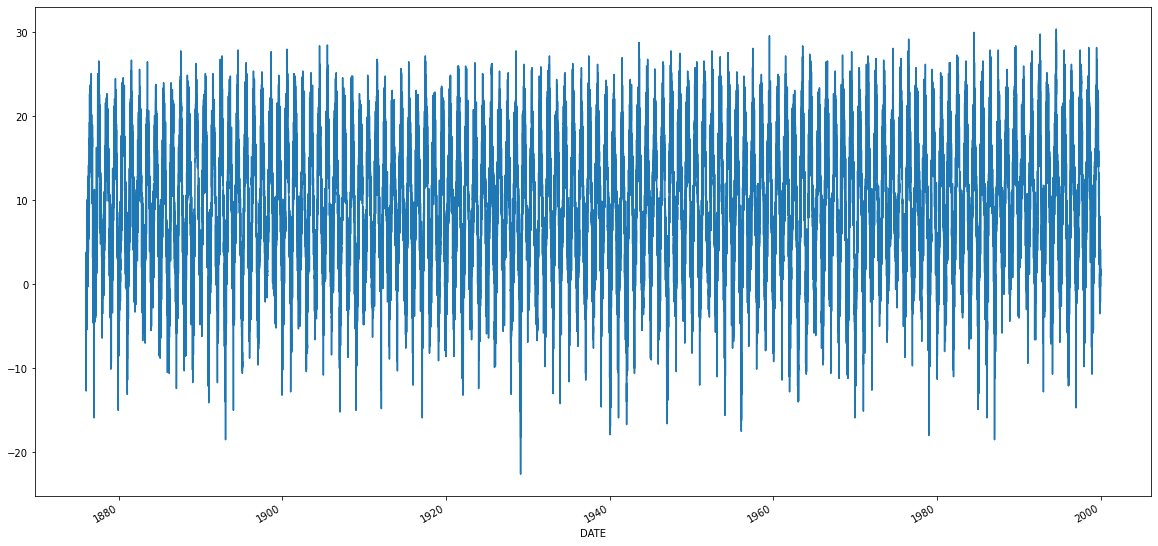

In [761]:
df_train['TG'].plot()

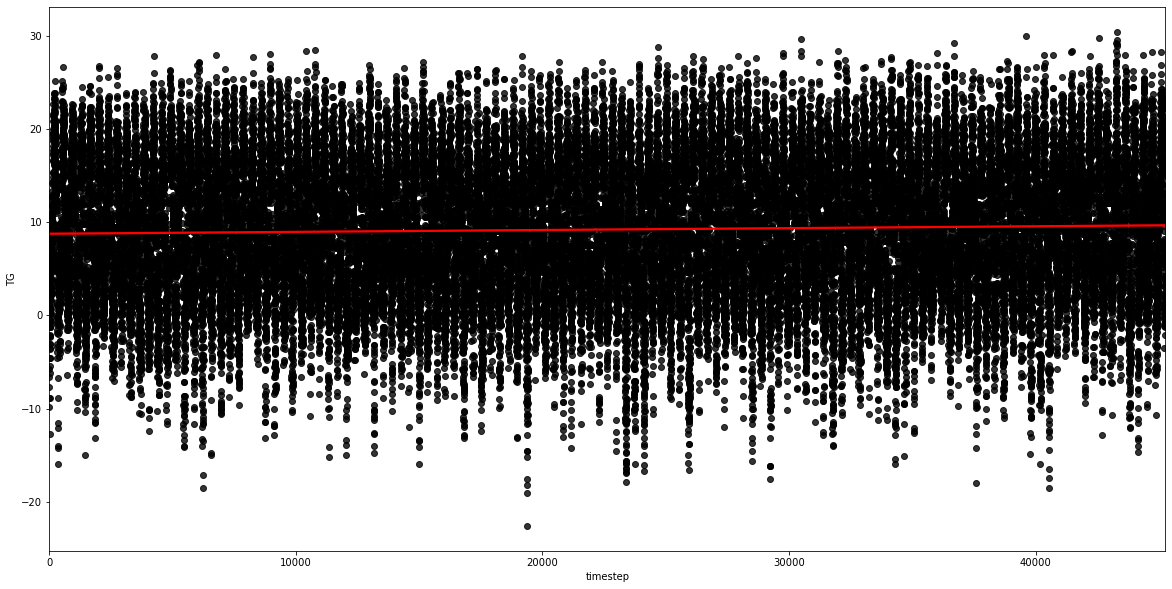

In [762]:
sns_plot = sns.regplot(x = 'timestep', y = 'TG', data = df_train, scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [763]:
df_train.head()

,TG,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [764]:
df_train['difference'] = df_train['TG'].diff(periods=1)             # Create difference column for removing trend

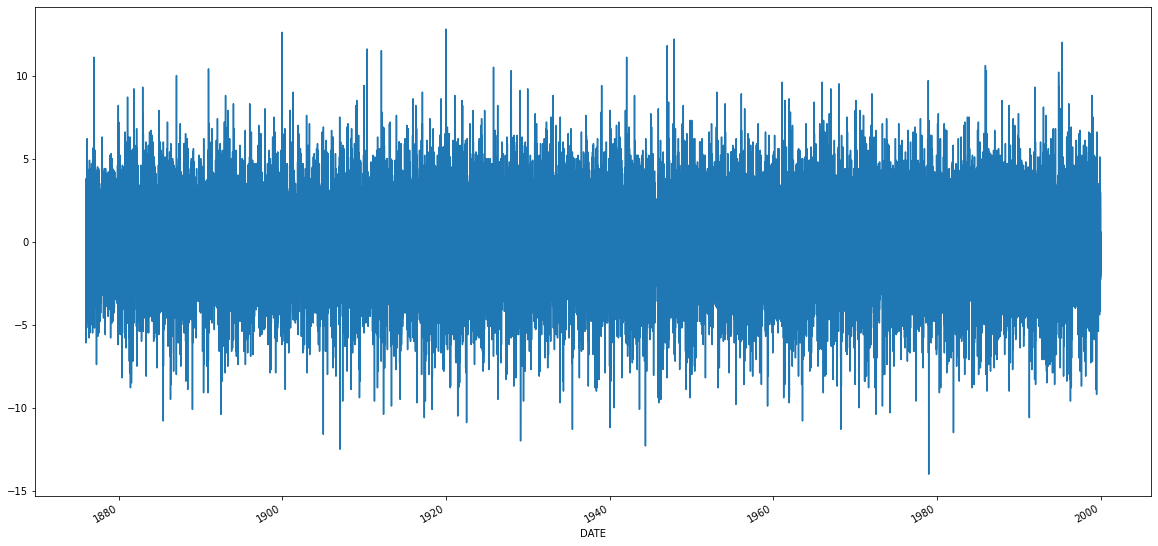

In [765]:
df_train['difference'].plot()

In [766]:
df_train['monthly mean'] = df_train.groupby(df_train.index.month)['difference'].transform('mean') # seasonality: create mean monthly difference column

In [767]:
monthlymeans = list(df_train.groupby(df_train.index.month)['difference'].mean()) # also save into a list

In [768]:
monthlymeans

[-0.007754358574030697,
 0.08309331797235031,
 0.14479708636836627,
 0.14723118279569825,
 0.17049947970863638,
 0.06573924731182815,
 0.03207596253902184,
 -0.0910509885535903,
 -0.1393413978494621,
 -0.18717481789802254,
 -0.12784946236559122,
 -0.08459937565036431]

In [769]:
df_train['deseasonalized'] = df_train['difference'] - df_train['monthly mean']

In [770]:
df_train['deseasonalized']

DATE
1876-01-01         NaN
1876-01-02    0.307754
1876-01-03   -2.192246
1876-01-04   -6.092246
1876-01-05   -3.992246
                ...   
1999-12-27   -1.015401
1999-12-28    0.284599
1999-12-29    0.284599
1999-12-30    0.684599
1999-12-31   -1.915401
Name: deseasonalized, Length: 45260, dtype: float64

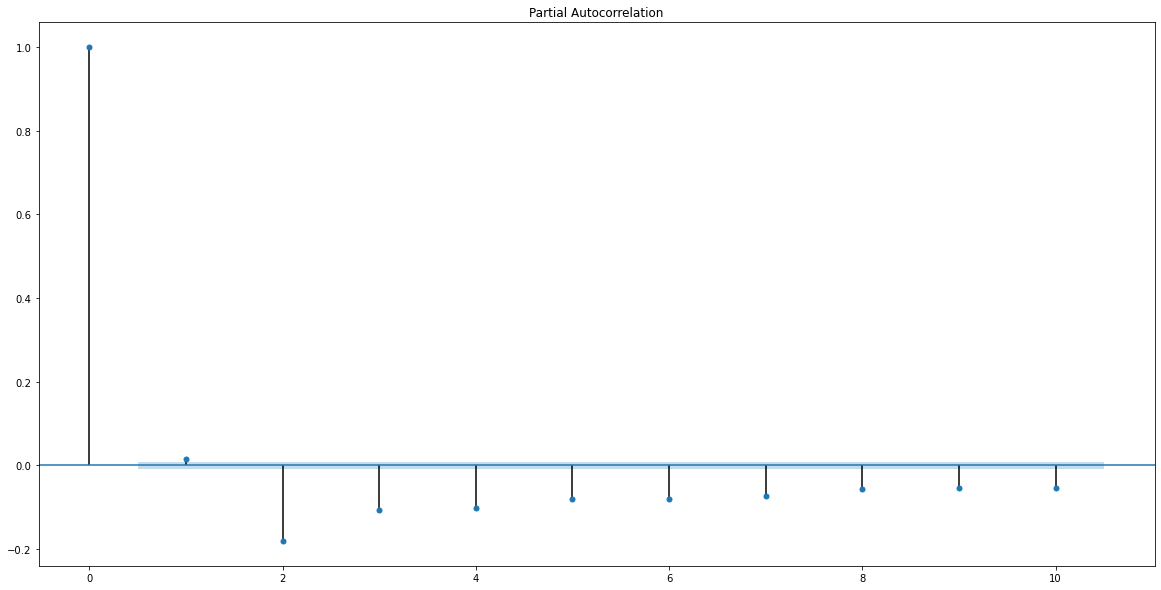

In [771]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train['deseasonalized'][3:], lags = 10)
plt.show()

In [772]:
ypred=df_train['deseasonalized'].mean()   # baseline (mean) prediction after trend and seasonality is removed

In [773]:
ypred

2.742012189677191e-17

In [774]:
df_train.head()

,TG,timestep,difference,monthly mean,deseasonalized
DATE,,,,,
1876-01-01,2.2,0,NaN,-0.007754,NaN
1876-01-02,2.5,1,0.3,-0.007754,0.307754
1876-01-03,0.3,2,-2.2,-0.007754,-2.192246
1876-01-04,-5.8,3,-6.1,-0.007754,-6.092246
1876-01-05,-9.8,4,-4.0,-0.007754,-3.992246


In [775]:
df_train['y-2']=df_train['deseasonalized'].shift(2)

In [776]:
df_train.head()

,TG,timestep,difference,monthly mean,deseasonalized,y-2
DATE,,,,,,
1876-01-01,2.2,0,NaN,-0.007754,NaN,NaN
1876-01-02,2.5,1,0.3,-0.007754,0.307754,NaN
1876-01-03,0.3,2,-2.2,-0.007754,-2.192246,NaN
1876-01-04,-5.8,3,-6.1,-0.007754,-6.092246,0.307754
1876-01-05,-9.8,4,-4.0,-0.007754,-3.992246,-2.192246


In [777]:
y_train = df_train['deseasonalized'][3:]       # dropping NaN values

In [778]:
y_train

DATE
1876-01-04   -6.092246
1876-01-05   -3.992246
1876-01-06    2.107754
1876-01-07    1.107754
1876-01-08   -2.292246
                ...   
1999-12-27   -1.015401
1999-12-28    0.284599
1999-12-29    0.284599
1999-12-30    0.684599
1999-12-31   -1.915401
Name: deseasonalized, Length: 45257, dtype: float64

In [779]:
x_train = df_train[['timestep','y-2']][3:]

In [780]:
x_train

,timestep,y-2
DATE,,
1876-01-04,3,0.307754
1876-01-05,4,-2.192246
1876-01-06,5,-6.092246
1876-01-07,6,-3.992246
1876-01-08,7,2.107754
...,...,...
1999-12-27,45255,2.384599
1999-12-28,45256,-2.215401
1999-12-29,45257,-1.015401


In [781]:
tr = ColumnTransformer([
    ('timesteps', 'passthrough', ['timestep']),
])

In [782]:
tr.fit(x_train)
x_train_trans = tr.transform(x_train)

In [783]:
x_train_trans

array([[    3],
       [    4],
       [    5],
       ...,
       [45257],
       [45258],
       [45259]])

In [784]:
x_test = df_test[['timestep']]

In [785]:
#x_test_trans = tr.transform(x_test)

In [786]:
linreg = LinearRegression()

In [787]:
#linreg.fit(x_train_trans, y_train)

In [788]:
linreg.fit(x_train, y_train)

LinearRegression()

In [789]:
cross_val_result = cross_val_score(linreg, x_train_trans, y_train)

In [790]:
cross_val_result

array([-7.87611665e-08, -4.36920754e-07, -4.52996419e-07, -5.14670573e-08,
       -3.72950337e-10])

In [791]:
linreg.score(x_train, y_train)

0.032506234421810554

In [792]:
df_test_predict = df_test.drop('TG',axis = 1)

In [793]:
df_test_predict

,timestep
DATE,
2000-01-01,45260
2000-01-02,45261
2000-01-03,45262
2000-01-04,45263
2000-01-05,45264
...,...
2020-09-26,52828
2020-09-27,52829
2020-09-28,52830


In [794]:
#predictions = linreg.predict(df_test_predict)

In [795]:
#predictions

In [796]:
df_test['y-2']=0    # this will be the y-2 column

In [797]:
df_test

,TG,timestep,y-2
DATE,,,
2000-01-01,1.4,45260,0
2000-01-02,3.9,45261,0
2000-01-03,5.9,45262,0
2000-01-04,5.3,45263,0
2000-01-05,3.0,45264,0
...,...,...,...
2020-09-26,10.4,52828,0
2020-09-27,9.9,52829,0
2020-09-28,13.9,52830,0


In [798]:
df_test_pred=pd.DataFrame(data={'predicted':[0]*7573,'predictedTG':[0]*7573}) # the first is the deseasoned/diffed value, the second the actual temperature prediction

In [799]:
df_test_pred['TG'] = df_test['TG'].values

In [800]:
df_test_pred['timestep'] = df_test['timestep'].values

In [801]:
df_test.drop(columns=['TG'], inplace=True)

In [802]:
df_test.loc[df_test['timestep']==45260,'y-2'] = df_train[df_train['timestep']==45258]['deseasonalized'][0]
df_test.loc[df_test['timestep']==45261,'y-2'] = df_train[df_train['timestep']==45259]['deseasonalized'][0]

In [803]:
df_test.head()

,timestep,y-2
DATE,,
2000-01-01,45260,0.684599
2000-01-02,45261,-1.915401
2000-01-03,45262,0.000000
2000-01-04,45263,0.000000
2000-01-05,45264,0.000000


In [804]:
df_test_pred.iloc[0,0] = linreg.predict(df_test[df_test['timestep']==45260])
df_test_pred.iloc[1,0] = linreg.predict(df_test[df_test['timestep']==45261])

In [805]:
df_test_pred.head()

,predicted,predictedTG,TG,timestep
0,-0.123322,0,1.4,45260
1,0.345444,0,3.9,45261
2,0.000000,0,5.9,45262
3,0.000000,0,5.3,45263
4,0.000000,0,3.0,45264


In [806]:
df_test.head()

,timestep,y-2
DATE,,
2000-01-01,45260,0.684599
2000-01-02,45261,-1.915401
2000-01-03,45262,0.000000
2000-01-04,45263,0.000000
2000-01-05,45264,0.000000


In [807]:
# predict the first steps of the test dataframe
currmonth = df_test[df_test['timestep']==45260].index.month[0]      
ypred_reconstruced = df_test_pred.iloc[0,0] + monthlymeans[currmonth-1]
# De-diff using the last observed value from the train dataframe:
ypred_temp_reconstruced = df_train[df_train['timestep']==45259]['TG'][0] + ypred_reconstruced
df_test_pred.loc[df_test_pred['timestep']==45260,'predictedTG'] = ypred_temp_reconstruced

currmonth = df_test[df_test['timestep']==45261].index.month[0]       
ypred_reconstruced = df_test_pred.loc[df_test_pred['timestep']==45261,'predicted']+ monthlymeans[currmonth-1]
# De-diff using the previous observed value from the test dataframe:
ypred_temp_reconstruced = df_test_pred.loc[df_test_pred['timestep']==45260,'predictedTG'][0] + ypred_reconstruced
df_test_pred.loc[df_test_pred['timestep']==45261,'predictedTG'] = ypred_temp_reconstruced



In [808]:
df_test_pred.head()

,predicted,predictedTG,TG,timestep
0,-0.123322,-0.331077,1.4,45260
1,0.345444,0.006613,3.9,45261
2,0.000000,0.000000,5.9,45262
3,0.000000,0.000000,5.3,45263
4,0.000000,0.000000,3.0,45264


In [809]:
df_test.head()

,timestep,y-2
DATE,,
2000-01-01,45260,0.684599
2000-01-02,45261,-1.915401
2000-01-03,45262,0.000000
2000-01-04,45263,0.000000
2000-01-05,45264,0.000000


In [810]:
# Do the prediction for the test dataframe step by step:
for i in range(45262, 52833):
# 52833
    currmonth = df_test[df_test['timestep']==i].index.month[0]
#    print(df_test_pred.loc[df_test_pred['timestep']==i-2,'predicted'])
    df_test.loc[df_test['timestep']==i,'y-2'] = df_test_pred.loc[df_test_pred['timestep']==i-2,'predicted'].values[0]
    df_test_pred.loc[df_test_pred['timestep']==i,'predicted'] = linreg.predict(df_test[df_test['timestep']==i-2])
    ypred_reconstruced = df_test_pred.loc[df_test_pred['timestep']==i,'predicted'].values[0] + monthlymeans[currmonth-1]
#    print(df_test_pred.loc[df_test_pred['timestep']==i-1,'predictedTG'])
#    print(df_test_pred.loc[df_test_pred['timestep']==i,'predicted'].values[0])
    ypred_temp_reconstruced = df_test_pred.loc[df_test_pred['timestep']==i-1,'predictedTG'].values[0] + ypred_reconstruced    
#    print(ypred_temp_reconstruced)
    df_test_pred.loc[df_test_pred['timestep']==i,'predictedTG'] = ypred_temp_reconstruced
    


In [811]:
df_test_pred.loc[df_test_pred['timestep']==i-2,'predicted'].values[0]

0.00010826118244474076

In [812]:
df_test.head()

,timestep,y-2
DATE,,
2000-01-01,45260,0.684599
2000-01-02,45261,-1.915401
2000-01-03,45262,-0.123322
2000-01-04,45263,0.345444
2000-01-05,45264,-0.123322


In [815]:
df_test_pred

,predicted,predictedTG,TG,timestep
0,-0.123322,-0.331077,1.4,45260
1,0.345444,0.006613,3.9,45261
2,-0.123322,-0.124464,5.9,45262
3,0.345444,0.213226,5.3,45263
4,0.022342,0.227813,3.0,45264
...,...,...,...,...
7568,0.000108,13.340274,10.4,52828
7569,0.000108,13.201041,9.9,52829
7570,0.000108,13.061808,13.9,52830
7571,0.000108,12.922574,14.4,52831


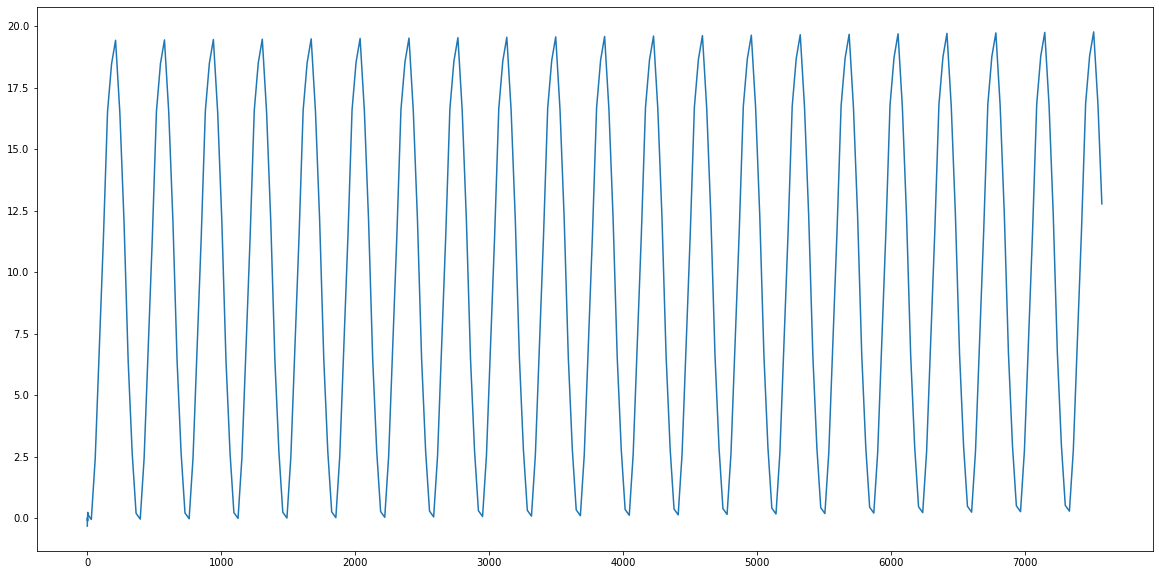

In [816]:
df_test_pred['predictedTG'].plot()

In [ ]:
#del df_test['timestep']            # don't really need this anymore after prediction

In [ ]:
#df_test['2004-01':'2020-01'].plot()          # display baseline model for a few years

In [829]:
drawframe=pd.DataFrame(data={'TG':df_test_pred['TG'],'predicted':df_test_pred['predictedTG']}) 

In [832]:
drawframe.index = df_test.index

In [833]:
drawframe

,TG,predicted
DATE,,
2000-01-01,1.4,-0.331077
2000-01-02,3.9,0.006613
2000-01-03,5.9,-0.124464
2000-01-04,5.3,0.213226
2000-01-05,3.0,0.227813
...,...,...
2020-09-26,10.4,13.340274
2020-09-27,9.9,13.201041
2020-09-28,13.9,13.061808


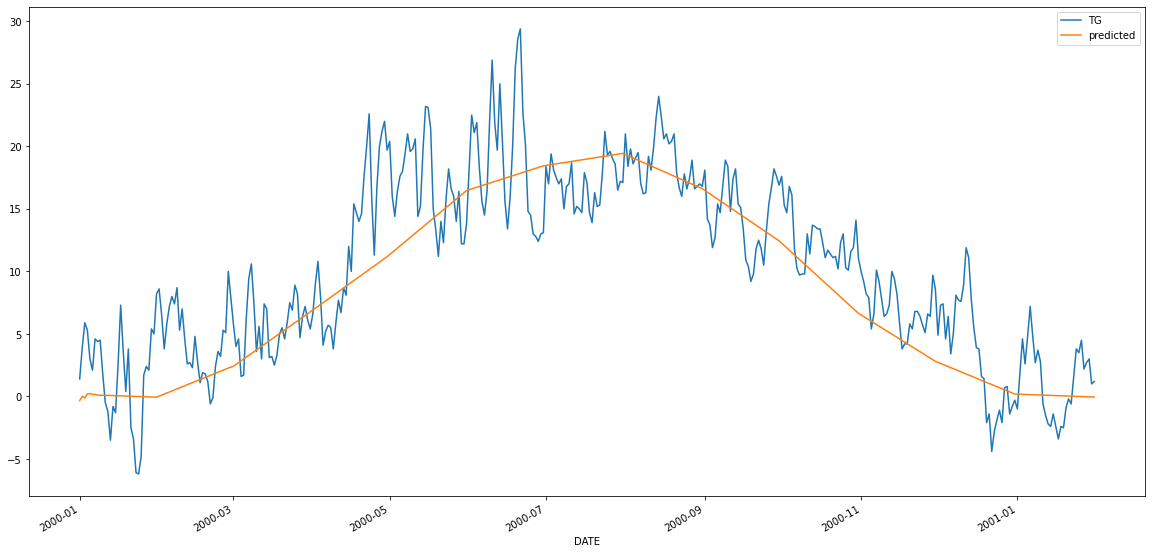

In [835]:
drawframe['2000-01':'2001-01'].plot()

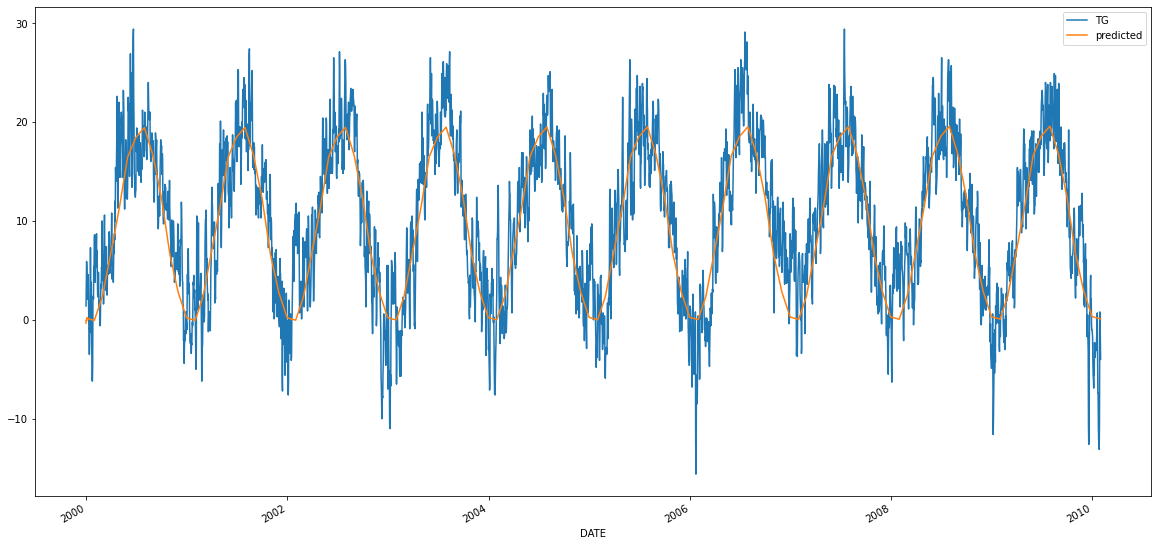

In [837]:
drawframe['2000-01':'2010-01'].plot()

In [839]:
print(mean_squared_error(df_test_pred['TG'], df_test_pred['predictedTG']))      # almost the same as with baseline model...

14.866590236916263


In [852]:
drawframe['2000-01':'2010-01']

,TG,predicted
DATE,,
2000-01-01,1.4,-0.331077
2000-01-02,3.9,0.006613
2000-01-03,5.9,-0.124464
2000-01-04,5.3,0.213226
2000-01-05,3.0,0.227813
...,...,...
2010-01-27,-10.0,0.122571
2010-01-28,0.8,0.114916
2010-01-29,0.6,0.107261


In [851]:
print(mean_squared_error(drawframe['TG'], drawframe['predicted'])) 

14.866590236916263
